In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
# json
import json
# sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

# lgb
import lightgbm as lgb

# datatime
import datetime
%matplotlib inline

In [2]:
def load_df(csv_path, nrows=None):
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in json_columns},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in json_columns:
        column_df = pd.io.json.json_normalize(list(df[column].values))
        column_df.columns = [f'{column}.{sub_column}' for sub_column in column_df.columns]
        df = df.drop(column, axis=1).join(column_df)
        
    return df

In [3]:
# load and transform data
#train_df = load_df('train.csv')
train_df = load_df('train.csv')
test_df = load_df('test.csv')

In [4]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


the ratio of non zero revenue is:  0.0127427231470487
the ratio of non zero revenue for unique users is:  0.013996726255903731


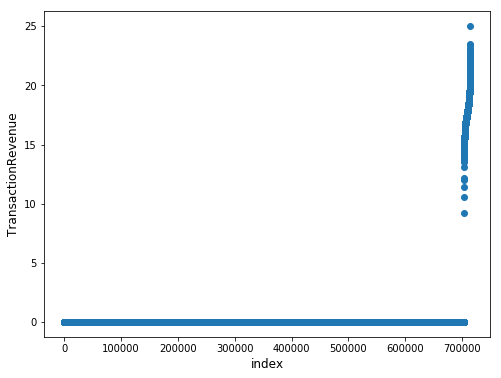

In [5]:
# target variable exploration
# convert target variables to float type
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)

# for every sample in training dataset
nonzero_ratio_train = sum(train_df['totals.transactionRevenue'] > 0) / train_df.shape[0]
print('the ratio of non zero revenue is: ', nonzero_ratio_train)

# for unique users in training dataset
revenue_sum = train_df.groupby(['fullVisitorId'])['totals.transactionRevenue'].sum().reset_index()
nonzero_ratio_unique_train = sum(revenue_sum['totals.transactionRevenue'] > 0) / revenue_sum.shape[0]
print('the ratio of non zero revenue for unique users is: ', nonzero_ratio_unique_train)

# plot revenue_sum
plt.figure(figsize=(8, 6))
plt.scatter(range(revenue_sum.shape[0]), np.sort(np.log1p(revenue_sum['totals.transactionRevenue'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [6]:
# number of unique visitors in train and test dataset and common visitors belong to both two datsets
print('number of unique visitors in train is {} out of rows {}'.format(train_df['fullVisitorId'].nunique(), train_df.shape[0]))
print('number of unique visitors in test is {} out of rows {}'.format(test_df['fullVisitorId'].nunique(), test_df.shape[0]))
print('number of common visitors in train and test is {}'.format(len(set(train_df['fullVisitorId'].unique()).intersection(set(test_df['fullVisitorId'].unique())))))

number of unique visitors in train is 714167 out of rows 903653
number of unique visitors in test is 617242 out of rows 804684
number of common visitors in train and test is 7679


In [7]:
# search for the constant features
constant_features = [c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1]

In [8]:
# drop constant features
train_df = train_df.drop(constant_features, axis=1)

In [9]:
# select categorical features
categorical_columns = [c for c in train_df.columns if train_df[c].dtype == 'O']
categorical_columns

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.campaignCode',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [10]:
# device browser exploration
browser_plot_info = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'mean']).reset_index()

In [11]:
# visualize device browser
tmp = train_df[train_df['totals.transactionRevenue'] != 0]
tmp = tmp.groupby('device.browser')['totals.transactionRevenue'].count().reset_index()
browser_plot_info = browser_plot_info.merge(tmp, on='device.browser', how='left')
browser_plot_info = browser_plot_info.rename(columns={'size': 'count', 'totals.transactionRevenue': 'count_nonzero'})

In [12]:
# sort
browser_plot_info = browser_plot_info.sort_values('count', ascending=False)
browser_plot_info = browser_plot_info.reset_index(drop=True)

Text(0.5,1,'mean revenue')

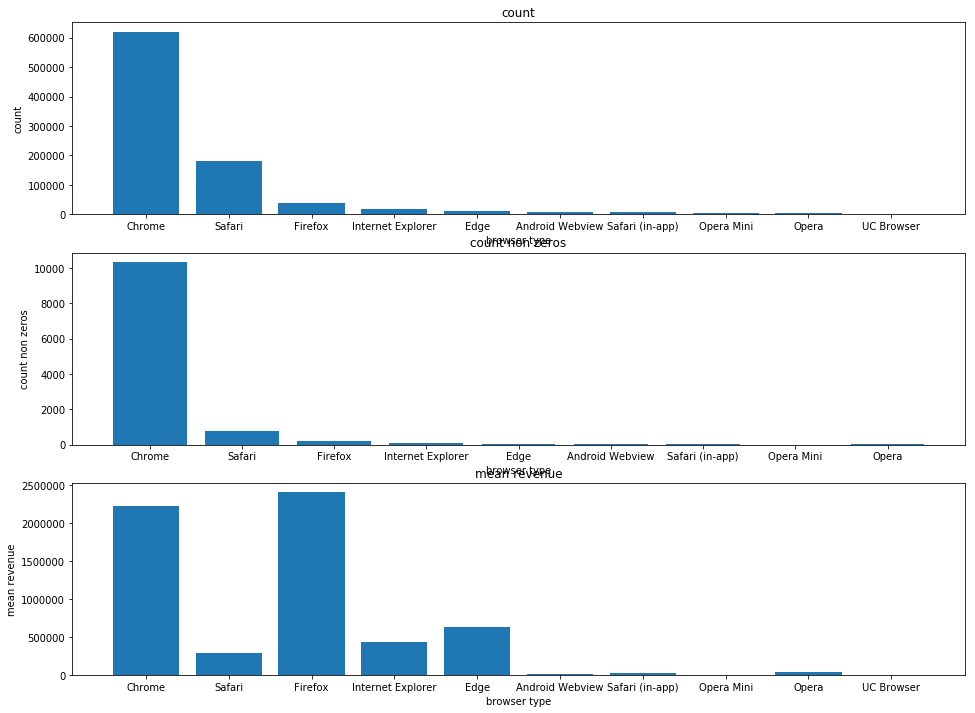

In [13]:
# histogram plot
browser_plot_info = browser_plot_info.head(10)
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.bar(browser_plot_info['device.browser'], browser_plot_info['count'])
plt.xlabel('browser type')
plt.ylabel('count')
plt.title('count')
plt.subplot(3, 1, 2)
plt.bar(browser_plot_info['device.browser'], browser_plot_info['count_nonzero'])
plt.xlabel('browser type')
plt.ylabel('count non zeros')
plt.title('count non zeros')
plt.subplot(3, 1, 3)
plt.bar(browser_plot_info['device.browser'], browser_plot_info['mean'])
plt.xlabel('browser type')
plt.ylabel('mean revenue')
plt.title('mean revenue')

In [14]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dty

In [15]:
# find the columns that train_df have while test_df dosen't

set(train_df.columns) - set(train_df.columns).intersection(set(test_df.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

In [16]:
# drop column trafficSource.campaignCode
train_df = train_df.drop(['trafficSource.campaignCode'], axis=1)

In [162]:
num_columns = ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber', 'visitStartTime']

In [18]:
cat_columns = ['channelGrouping',
             'device.browser',
             'device.deviceCategory',
             'device.operatingSystem',
             'geoNetwork.city',
             'geoNetwork.continent',
             'geoNetwork.country',
             'geoNetwork.metro',
             'geoNetwork.networkDomain',
             'geoNetwork.region',
             'geoNetwork.subContinent',
             'trafficSource.adContent',
             'trafficSource.adwordsClickInfo.adNetworkType',
             'trafficSource.adwordsClickInfo.gclId',
             'trafficSource.adwordsClickInfo.isVideoAd',
             'trafficSource.adwordsClickInfo.page',
             'trafficSource.adwordsClickInfo.slot',
             'trafficSource.campaign',
             'trafficSource.isTrueDirect',
             'trafficSource.keyword',
             'trafficSource.medium',
             'trafficSource.referralPath',
             'trafficSource.source']

In [19]:
# label encode categorical columns
def encode_cat_columns(train_df, test_df, column_list):
    for column in column_list:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[column].values.astype('str')) + list(test_df[column].values.astype('str')))
        train_df[column] = lbl.transform(list(train_df[column].values.astype('str')))
        test_df[column] = lbl.transform(list(test_df[column].values.astype('str')))
    return train_df, test_df

In [20]:
train_df, test_df = encode_cat_columns(train_df, test_df, cat_columns)

In [163]:
# copy train_df, test_df
train_df_copy, test_df_copy = train_df.copy(), test_df.copy()

train_df_copy =  train_df_copy[['date', 'fullVisitorId'] + num_columns + cat_columns + ['totals.transactionRevenue']]
train_df_copy = train_df_copy.fillna(0)

test_df_copy = test_df_copy[['date', 'fullVisitorId'] + num_columns + cat_columns]
test_df_copy = test_df_copy.fillna(0)

# convert num features to float
train_df_copy[num_columns] = train_df[num_columns].astype(float)
test_df_copy[num_columns] = test_df[num_columns].astype(float)

In [164]:
train_df_copy.head(20)

,date,fullVisitorId,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,visitNumber,visitStartTime,channelGrouping,device.browser,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,totals.transactionRevenue
0,20160902,1131660440785968503,1.0,1.0,1.0,1.0,1.0,1.472830e+09,4,35,...,1,11,3,4,1,11,5,3196,208,0.0
1,20160902,377306020877927890,1.0,1.0,1.0,1.0,1.0,1.472880e+09,4,43,...,1,11,3,4,1,11,5,3196,208,0.0
2,20160902,3895546263509774583,1.0,1.0,1.0,1.0,1.0,1.472865e+09,4,35,...,1,11,3,4,1,11,5,3196,208,0.0
3,20160902,4763447161404445595,1.0,1.0,1.0,1.0,1.0,1.472881e+09,4,79,...,1,11,3,4,1,1607,5,3196,208,0.0
4,20160902,27294437909732085,1.0,1.0,NaN,1.0,2.0,1.472823e+09,4,35,...,1,11,3,4,0,11,5,3196,208,0.0
5,20160902,2938943183656635653,1.0,1.0,1.0,1.0,1.0,1.472807e+09,4,35,...,1,11,3,4,1,11,5,3196,208,0.0
6,20160902,1905672039242460897,1.0,1.0,1.0,1.0,1.0,1.472817e+09,4,35,...,1,11,3,4,1,11,5,3196,208,0.0
7,20160902,537222803633850821,1.0,1.0,1.0,1.0,1.0,1.472813e+09,4,35,...,1,11,3,4,1,11,5,3196,208,0.0
8,20160902,4445454811831400414,1.0,1.0,1.0,1.0,1.0,1.472806e+09,4,47,...,1,11,3,4,1,11,5,3196,208,0.0
9,20160902,9499785259412240342,1.0,1.0,1.0,1.0,1.0,1.472812e+09,4,43,...,1,11,3,4,1,11,5,3196,208,0.0


In [94]:
# separate visitor id
train = train_df_copy[train_df_copy['date'] <= 20170531]
dev = train_df_copy[train_df_copy['date'] > 20170531]

train_id = train['fullVisitorId'].values
train_X = train[num_columns + cat_columns] # do not convert to np.array type for latter plot of featrure importance  usage
train_y = train['totals.transactionRevenue'].values

dev_id = dev['fullVisitorId'].values
dev_X = dev[num_columns + cat_columns].values
dev_y = dev['totals.transactionRevenue'].values

test_id = test_df_copy['fullVisitorId'].values
test_X = test_df[num_columns + cat_columns].values

In [95]:
# convert train_y, dev_y to natural log form
train_y = np.log1p(train_y)
dev_y = np.log1p(dev_y)

In [96]:
def run_lgb(X_train, y_train, X_dev, y_dev, X_test):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 30,
        'min_child_samples': 100,
        'learning_rate': 0.1,
        'bagging_fraction': 0.7,
        'feature_fraction': 0.5,
        'bagging_frequency': 5,
        'bagging_seed': 2018,
        'verbosity': -1
    }
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_dev = lgb.Dataset(X_dev, label=y_dev)
    model = lgb.train(params, lgb_train, valid_sets=[lgb_dev], early_stopping_rounds=100, verbose_eval=100)
    pred_y_test = model.predict(X_test, num_iteration=model.best_iteration) 
    pred_y_dev = model.predict(X_dev, num_iteration=model.best_iteration)
    return model, pred_y_dev, pred_y_test

In [97]:
model, pred_dev, pred_test = run_lgb(train_X, train_y, dev_X, dev_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69987
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.69987


In [98]:
# metrics(rmse)

# convert predict value to 0 if it is less than 0
pred_dev[pred_dev < 0] = 0
pred_dev_df = pd.DataFrame({'fullVisitorID': dev_id})
pred_dev_df['transactionRevenue'] = dev_y
pred_dev_df['predictedRevenue'] = np.expm1(pred_dev)
pred_dev_df = pred_dev_df.groupby('fullVisitorID')[['transactionRevenue', 'predictedRevenue']].sum()

In [99]:
# rmse from validation results
pred_dev_df = pred_dev_df.reset_index()
np.sqrt(metrics.mean_squared_error(np.log1p(pred_dev_df['transactionRevenue'].values), np.log1p(pred_dev_df['predictedRevenue'].values)))

1.065871409227663

In [100]:
# submission
submission = pd.read_csv('sample_submission.csv')

In [101]:
pred_test[pred_test < 0] = 0
pred_test_df = pd.DataFrame({'fullVisitorID': test_id})
pred_test_df['predict'] = np.expm1(pred_test)
pred_test_df = pred_test_df.groupby('fullVisitorID')['predict'].sum().reset_index()

In [102]:
pred_test_df['predict'] = np.log1p(pred_test_df['predict'].values)

In [103]:
submission = submission.merge(pred_test_df, left_on='fullVisitorId', right_on='fullVisitorID')

In [104]:
submission.head()

,fullVisitorId,PredictedLogRevenue,fullVisitorID,predict
0,0000000259678714014,0.0,0000000259678714014,1.334467
1,0000049363351866189,0.0,0000049363351866189,0.000000
2,0000053049821714864,0.0,0000053049821714864,0.000000
3,0000059488412965267,0.0,0000059488412965267,0.000000
4,0000085840370633780,0.0,0000085840370633780,0.052554


In [105]:
submission =submission.drop(['PredictedLogRevenue', 'fullVisitorID'], axis=1)
submission.columns = ['fullVisitorId', 'PredictedLogRevenue']

In [106]:
submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,1.334467
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.052554


In [107]:
submission.to_csv('submission.csv', index=0)

Text(0.5,1,'Light-GBM Feature Importance')

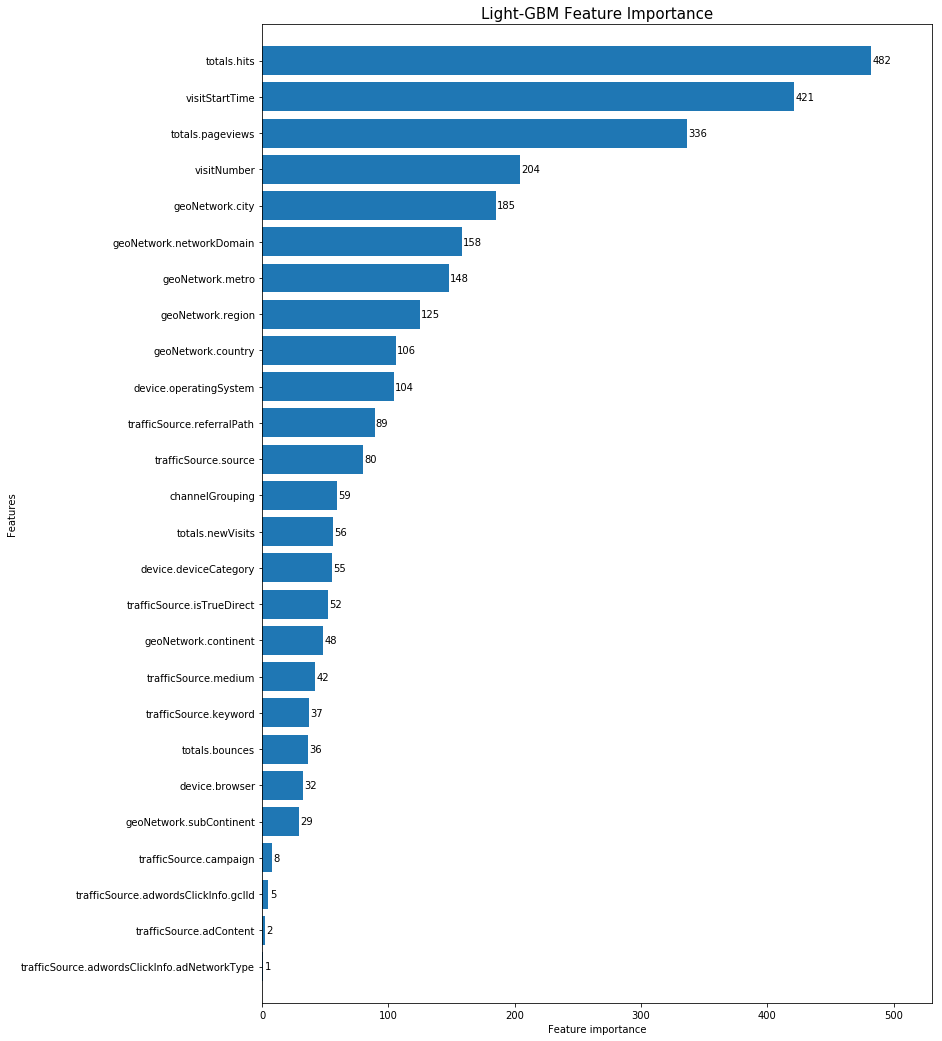

In [108]:
# visualize feature importance
fig, ax = plt.subplots(figsize=(12, 18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title('Light-GBM Feature Importance', fontsize=15)

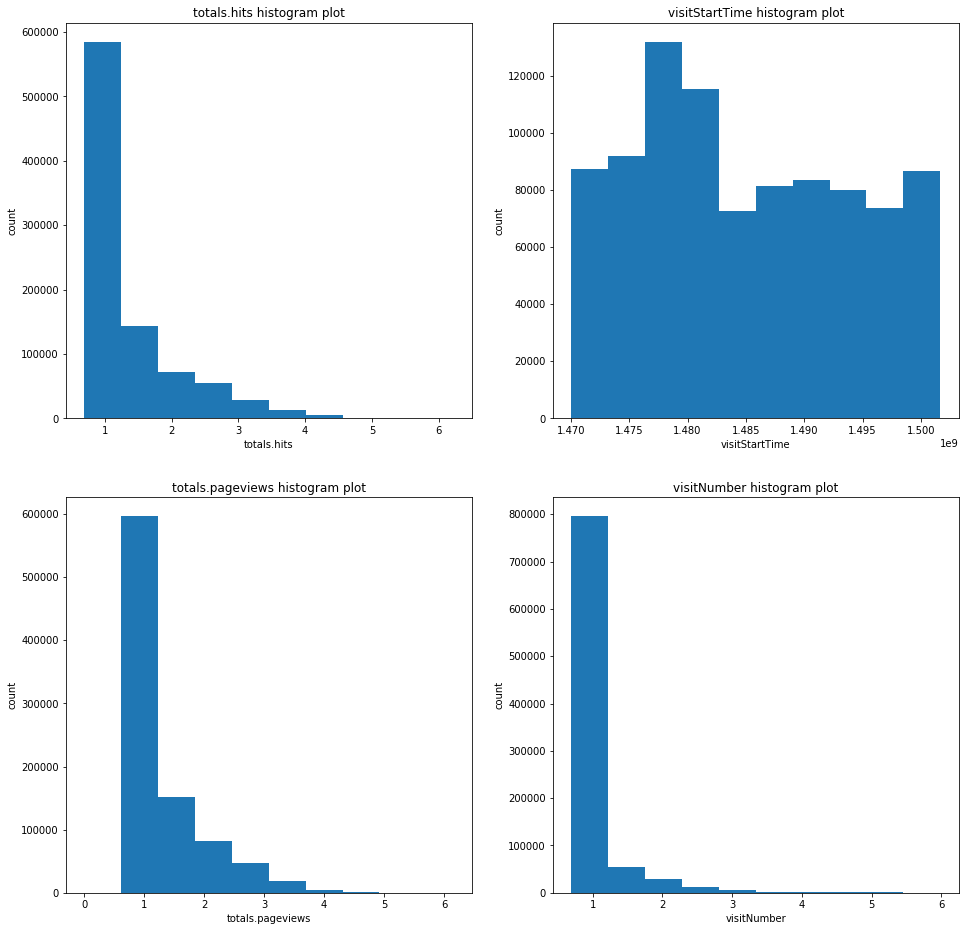

In [129]:
# plot histgram and explore distribution of totals.hits, visitStartTime, totals.pageviews, visitNumber
plt.figure(figsize=(16, 16))
i = 1
for feature in ['totals.hits', 'visitStartTime', 'totals.pageviews', 'visitNumber']:
    train_df_copy[feature] = train_df_copy[feature].fillna(0)
    train_df_copy[feature] = train_df_copy[feature].astype(float)
    plt.subplot(2, 2, i)
    plt.hist(train_df_copy[feature])
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title(feature + ' histogram plot')
    i += 1
plt.show()

In [165]:
# convert totals.hits, totals.pageviews, visitNumber to natrual log form
train_df_copy[['totals.hits', 'totals.pageviews', 'visitNumber']] = np.log1p(train_df_copy[['totals.hits', 'totals.pageviews', 'visitNumber']])

In [166]:
# might need to fillna 0 later
test_df_copy[['totals.hits', 'totals.pageviews', 'visitNumber']] = np.log1p(test_df_copy[['totals.hits', 'totals.pageviews', 'visitNumber']])

In [167]:
# convert visitStartTime to day of week, hours and day of month
def parse_visit_time(df):
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['dow'] = df['visitStartTime'].dt.dayofweek
    df['hours'] = df['visitStartTime'].dt.hour
    df['dom'] = df['visitStartTime'].dt.day

In [168]:
for df in [train_df_copy, test_df_copy]:
    parse_visit_time(df)

In [169]:
train_df_copy = train_df_copy.drop('visitStartTime', axis=1)
test_df_copy = test_df_copy.drop('visitStartTime', axis=1)

In [171]:
num_columns = ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber', 'dow', 'hours', 'dom']

In [176]:
# separate visitor id
train = train_df_copy[train_df_copy['date'] <= 20170531]
dev = train_df_copy[train_df_copy['date'] > 20170531]

train_id = train['fullVisitorId'].values
train_X = train[num_columns + cat_columns] # do not convert to np.array type for latter plot of featrure importance  usage
train_y = train['totals.transactionRevenue'].values

dev_id = dev['fullVisitorId'].values
dev_X = dev[num_columns + cat_columns].values
dev_y = dev['totals.transactionRevenue'].values

test_id = test_df_copy['fullVisitorId'].values
test_X = test_df_copy[num_columns + cat_columns].values

In [177]:
# convert train_y, dev_y to natural log form
train_y = np.log1p(train_y)
dev_y = np.log1p(dev_y)

In [178]:
model, pred_dev, pred_test = run_lgb(train_X, train_y, dev_X, dev_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72117
Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 1.72111


In [179]:
# metrics(rmse)

# convert predict value to 0 if it is less than 0
pred_dev[pred_dev < 0] = 0
pred_dev_df = pd.DataFrame({'fullVisitorID': dev_id})
pred_dev_df['transactionRevenue'] = dev_y
pred_dev_df['predictedRevenue'] = np.expm1(pred_dev)
pred_dev_df = pred_dev_df.groupby('fullVisitorID')[['transactionRevenue', 'predictedRevenue']].sum()

In [180]:
# rmse from validation results
pred_dev_df = pred_dev_df.reset_index()
np.sqrt(metrics.mean_squared_error(np.log1p(pred_dev_df['transactionRevenue'].values), np.log1p(pred_dev_df['predictedRevenue'].values)))

0.8542111644314502

In [181]:
submission = pd.read_csv('sample_submission.csv')
pred_test[pred_test < 0] = 0
pred_test_df = pd.DataFrame({'fullVisitorID': test_id})
pred_test_df['predict'] = np.expm1(pred_test)
pred_test_df = pred_test_df.groupby('fullVisitorID')['predict'].sum().reset_index()

In [182]:
pred_test_df['predict'] = np.log1p(pred_test_df['predict'].values)

In [183]:
submission = submission.merge(pred_test_df, left_on='fullVisitorId', right_on='fullVisitorID')

In [185]:
submission =submission.drop(['PredictedLogRevenue', 'fullVisitorID'], axis=1)
submission.columns = ['fullVisitorId', 'PredictedLogRevenue']

In [186]:
submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.840324
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.089473


In [187]:
submission.to_csv('submission2.csv', index=0)